# Práctica 4b
### Comparación entre Tesseract, SmolVLM y easyOCR

### Script para recorde de imágenes:

Con  nuestro modelo entrenado se recorre el dataset para obtener el bounding box de la matrícula y recortar la imagen y así quedarnos con solo las imágenes de las matrículas

In [ ]:
import os
import cv2
from ultralytics import YOLO
from pathlib import Path


def crop_and_save_detections(
    model_path,
    input_dir,
    output_dir,
    conf_threshold=0.5,
    class_filter=None,
    save_empty_images=False
):
    
    model = YOLO(model_path)
    
    output_path = Path(output_dir)
    output_path.mkdir(parents=True, exist_ok=True)
    
    if save_empty_images:
        no_detection_path = output_path / "sin_detecciones"
        no_detection_path.mkdir(exist_ok=True)
    
    valid_extensions = {'.jpg', '.jpeg', '.png', '.heic', '.HEIC', '.webp'}
    
    input_path = Path(input_dir)
    image_files = [
        f for f in input_path.iterdir() 
        if f.suffix.lower() in valid_extensions and len(f.stem.split("_" )) == 1
    ]
    
    stats = {
        'total_images': len(image_files),
        'images_with_detections': 0,
        'images_without_detections': 0,
        'total_crops': 0,
        'crops_per_class': {}
    }
    
    # Procesar cada imagen
    for idx, image_file in enumerate(image_files, 1):
        img = cv2.imread(str(image_file))
        
        if img is None:
            print(f"Error al leer: {image_file.name}")
            continue
        
        results = model.predict(
            img,
            conf=conf_threshold,
            classes=class_filter,
            save=False,
            verbose=False
        )
        
        detections = results[0].boxes
        num_detections = len(detections)
        
        # Si no hay detección alguna
        if num_detections == 0:
            stats['images_without_detections'] += 1
            
            if save_empty_images:
                output_file = no_detection_path / image_file.name
                cv2.imwrite(str(output_file), img)
            
            print(f"[{idx}/{len(image_files)}] {image_file.name}: 0 detecciones")
            continue
        
        stats['images_with_detections'] += 1
        
        for det_idx, box in enumerate(detections):
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            conf = box.conf[0].item()
            cls_id = int(box.cls[0].item())
            
            if x2 <= x1 or y2 <= y1:
                continue
            
            crop = img[y1:y2, x1:x2]
            
            if crop.size == 0:
                continue
            
            name_without_ext = image_file.stem
            crop_filename = f"{name_without_ext}.jpg"
            crop_path = output_path / crop_filename
            
            cv2.imwrite(str(crop_path), crop)
            
            stats['total_crops'] += 1
            stats['crops_per_class'][cls_id] = stats['crops_per_class'].get(cls_id, 0) + 1
        
        print(f"[{idx}/{len(image_files)}] {image_file.name}: {num_detections} detecciones → {num_detections} recortes guardados")
    
    print("\n" + "=" * 70)
    print("RESUMEN DEL PROCESAMIENTO")
    print("=" * 70)
    print(f"Total de imágenes procesadas:     {stats['total_images']}")
    print(f"Imágenes CON detecciones:         {stats['images_with_detections']}")
    print(f"Imágenes SIN detecciones:         {stats['images_without_detections']}")
    print(f"Total de recortes guardados:      {stats['total_crops']}")
    print("\nRecortes por clase:")
    for cls_id, count in sorted(stats['crops_per_class'].items()):
        print(f"  Clase {cls_id}: {count} recortes")
    print("=" * 70)
    
    return stats

In [ ]:
stats = crop_and_save_detections(
    model_path="runs/detect/license_plate_augmented/weights/best.pt",
    input_dir="C:/Users/asmae/Documents/INGENIERIA INFORMATICA/4 CUARTO/VC/Practicas/VC_P4&P5/dataset/train/images",
    output_dir="C:/Users/asmae/Documents/INGENIERIA INFORMATICA/4 CUARTO/VC/Practicas/VC_P4&P5/dataset_matriculas_recortadas",
    conf_threshold=0.5  
)

stats = crop_and_save_detections(
    model_path="runs/detect/license_plate_augmented/weights/best.pt",
    input_dir="C:/Users/asmae/Documents/INGENIERIA INFORMATICA/4 CUARTO/VC/Practicas/VC_P4&P5/dataset/val/images",
    output_dir="C:/Users/asmae/Documents/INGENIERIA INFORMATICA/4 CUARTO/VC/Practicas/VC_P4&P5/dataset_matriculas_recortadas",
    conf_threshold=0.5 
)

## Métricas comparación entre Tessercat, SmolVLM y easyOCR

In [ ]:
import os
import cv2
import time
import pytesseract
import torch
from pathlib import Path
from transformers import AutoProcessor, AutoModelForVision2Seq
from PIL import Image
import pandas as pd
import re


class OCRComparator:
    
    def __init__(self, tesseract_path=None):
    
        if tesseract_path:
            pytesseract.pytesseract.tesseract_cmd = tesseract_path
        
        print("Cargando modelo SmolVLM...")
        self.processor = AutoProcessor.from_pretrained("HuggingFaceTB/SmolVLM-Instruct")
        self.model = AutoModelForVision2Seq.from_pretrained(
            "HuggingFaceTB/SmolVLM-Instruct",
            torch_dtype=torch.float16,
            device_map="auto",
            offload_folder="./offload",
            offload_state_dict=True
        )
        print("SmolVLM cargado correctamente\n")
        
        self.smolvlm_prompt = "Extract the license plate number from this image. Return only the alphanumeric characters, no spaces or special characters."
    
    def normalize_plate_text(self, text):
        if not text:
            return ""
        
        text = text.upper().strip()
        text = re.sub(r'[^A-Z0-9]', '', text)
        
        return text
    
    def ocr_tesseract(self, image_path):
        start_time = time.time()
        
        try:
            img = cv2.imread(str(image_path))
            
            if img is None:
                return None, 0
            
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            custom_config = r'--oem 3 --psm 7 -c tessedit_char_whitelist=ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789'
            
            text = pytesseract.image_to_string(img_rgb, config=custom_config)
            
            text = self.normalize_plate_text(text)
            
            elapsed_time = time.time() - start_time
            
            return text, elapsed_time
        
        except Exception as e:
            print(f"Error en Tesseract con {image_path.name}: {e}")
            return None, 0
    
    def ocr_smolvlm(self, image_path):
        start_time = time.time()
        
        try:
            image = Image.open(image_path).convert('RGB')
            messages = [
                {
                    "role": "user",
                    "content": [
                        {"type": "image"},
                        {"type": "text", "text": self.smolvlm_prompt}
                    ]
                }
            ]
            
            prompt = self.processor.apply_chat_template(messages, add_generation_prompt=True)
            inputs = self.processor(
                text=prompt,
                images=[image],
                return_tensors="pt"
            )
            
            # Mover a GPU si es que está disponible
            inputs = {k: v.to(self.model.device) for k, v in inputs.items()}
            
            with torch.no_grad():
                generated_ids = self.model.generate(
                    **inputs,
                    max_new_tokens=50,
                    do_sample=False
                )
            
            generated_ids_trimmed = [
                out_ids[len(in_ids):] 
                for in_ids, out_ids in zip(inputs['input_ids'], generated_ids)
            ]
            
            output_text = self.processor.batch_decode(
                generated_ids_trimmed,
                skip_special_tokens=True,
                clean_up_tokenization_spaces=False
            )[0]
            
            text = self.normalize_plate_text(output_text)
            
            elapsed_time = time.time() - start_time
            
            return text, elapsed_time
        
        except Exception as e:
            print(f"Error en SmolVLM con {image_path.name}: {e}")
            return None, 0
    
    def calculate_accuracy_metrics(self, predicted, ground_truth):
        
        if predicted is None or ground_truth is None:
            return {
                'exact_match': False,
                'char_accuracy': 0.0,
                'levenshtein_distance': float('inf')
            }
        
        pred = self.normalize_plate_text(predicted)
        gt = self.normalize_plate_text(ground_truth)
        
        exact_match = (pred == gt)
        
        if len(gt) == 0:
            char_accuracy = 1.0 if len(pred) == 0 else 0.0
        else:
            matches = sum(1 for p, g in zip(pred, gt) if p == g)
            char_accuracy = matches / max(len(pred), len(gt))
        
        lev_dist = self.levenshtein_distance(pred, gt)
        
        return {
            'exact_match': exact_match,
            'char_accuracy': char_accuracy,
            'levenshtein_distance': lev_dist
        }
    
    @staticmethod
    def levenshtein_distance(s1, s2):
        if len(s1) < len(s2):
            return OCRComparator.levenshtein_distance(s2, s1)
        
        if len(s2) == 0:
            return len(s1)
        
        previous_row = range(len(s2) + 1)
        for i, c1 in enumerate(s1):
            current_row = [i + 1]
            for j, c2 in enumerate(s2):
                insertions = previous_row[j + 1] + 1
                deletions = current_row[j] + 1
                substitutions = previous_row[j] + (c1 != c2)
                current_row.append(min(insertions, deletions, substitutions))
            previous_row = current_row
        
        return previous_row[-1]
    
    def compare_ocr_methods(self, images_dir, output_csv="ocr_comparison_results.csv"):
    
        images_path = Path(images_dir)
        valid_extensions = {'.jpg', '.jpeg', '.png', '.bmp'}
        image_files = [
            f for f in images_path.iterdir() 
            if f.suffix.lower() in valid_extensions
        ]
        
        print(f"Encontradas {len(image_files)} imágenes en {images_dir}")
        print(f"Iniciando comparativa OCR...\n")
        print("=" * 80)
        
        results = []
        
        for idx, img_file in enumerate(image_files, 1):
            ground_truth = img_file.stem
            
            print(f"\n[{idx}/{len(image_files)}] Procesando: {img_file.name}")
            print(f"  Ground Truth: {ground_truth}")
            
            print("Tesseract...", end=" ")
            tess_text, tess_time = self.ocr_tesseract(img_file)
            tess_metrics = self.calculate_accuracy_metrics(tess_text, ground_truth)
            print(f"✓ ({tess_time:.3f}s) → {tess_text}")
            
            print("SmolVLM...", end=" ")
            smol_text, smol_time = self.ocr_smolvlm(img_file)
            smol_metrics = self.calculate_accuracy_metrics(smol_text, ground_truth)
            print(f"✓ ({smol_time:.3f}s) → {smol_text}")
            
            result = {
                'image_name': img_file.name,
                'ground_truth': ground_truth,
                
                'tesseract_output': tess_text or "",
                'tesseract_time': tess_time,
                'tesseract_exact_match': tess_metrics['exact_match'],
                'tesseract_char_accuracy': tess_metrics['char_accuracy'],
                'tesseract_levenshtein': tess_metrics['levenshtein_distance'],
                
                'smolvlm_output': smol_text or "",
                'smolvlm_time': smol_time,
                'smolvlm_exact_match': smol_metrics['exact_match'],
                'smolvlm_char_accuracy': smol_metrics['char_accuracy'],
                'smolvlm_levenshtein': smol_metrics['levenshtein_distance'],
            }
            
            results.append(result)
        
        df = pd.DataFrame(results)
        
        df.to_csv(output_csv, index=False, encoding='utf-8')
        print(f"\nResultados guardados en: {output_csv}")
        
        self.print_summary(df)
        
        return df
    
    def print_summary(self, df):
        print("\n" + "=" * 80)
        print("RESUMEN DE LA COMPARATIVA")
        print("=" * 80)
        
        total = len(df)
        
        # Tesseract
        tess_exact = df['tesseract_exact_match'].sum()
        tess_avg_time = df['tesseract_time'].mean()
        tess_avg_accuracy = df['tesseract_char_accuracy'].mean()
        
        # SmolVLM
        smol_exact = df['smolvlm_exact_match'].sum()
        smol_avg_time = df['smolvlm_time'].mean()
        smol_avg_accuracy = df['smolvlm_char_accuracy'].mean()
        
        print(f"\nTotal de imágenes: {total}")
        
        print(f"\nTESSERACT:")
        print(f"✓ Aciertos exactos:        {tess_exact}/{total} ({tess_exact/total*100:.1f}%)")
        print(f"Precisión por carácter:  {tess_avg_accuracy*100:.1f}%")
        print(f"Tiempo promedio:        {tess_avg_time:.3f}s")
        print(f" Velocidad total:         {total*tess_avg_time:.1f}s ({total/tess_avg_time:.1f} img/s)")
        
        print(f"\nSMOLVLM:")
        print(f"✓ Aciertos exactos:        {smol_exact}/{total} ({smol_exact/total*100:.1f}%)")
        print(f"Precisión por carácter:  {smol_avg_accuracy*100:.1f}%")
        print(f"Tiempo promedio:        {smol_avg_time:.3f}s")
        print(f"Velocidad total:         {total*smol_avg_time:.1f}s ({total/smol_avg_time:.1f} img/s)")
        
        print(f"\nCOMPARACIÓN:")
        winner_accuracy = "Tesseract" if tess_exact > smol_exact else "SmolVLM" if smol_exact > tess_exact else "Empate"
        winner_speed = "Tesseract" if tess_avg_time < smol_avg_time else "SmolVLM"
        speedup = smol_avg_time / tess_avg_time if tess_avg_time < smol_avg_time else tess_avg_time / smol_avg_time
        
        print(f"\nMás preciso:     {winner_accuracy}")
        print(f"Más rápido:      {winner_speed} ({speedup:.1f}x más rápido)")
        print(f"Diferencia:      {abs(smol_exact - tess_exact)} aciertos de diferencia")
        
        print("=" * 80)



In [ ]:
import easyocr
import cv2
import time
import re
from pathlib import Path
import pandas as pd

def normalize_plate_text(text):
    if not text:
        return ""
    text = text.upper().strip()
    text = re.sub(r'[^A-Z0-9]', '', text)
    return text

def levenshtein_distance(s1, s2):
    if len(s1) < len(s2):
        return levenshtein_distance(s2, s1)
    if len(s2) == 0:
        return len(s1)
    
    previous_row = range(len(s2) + 1)
    for i, c1 in enumerate(s1):
        current_row = [i + 1]
        for j, c2 in enumerate(s2):
            insertions = previous_row[j + 1] + 1
            deletions = current_row[j] + 1
            substitutions = previous_row[j] + (c1 != c2)
            current_row.append(min(insertions, deletions, substitutions))
        previous_row = current_row
    
    return previous_row[-1]

def calculate_accuracy_metrics(predicted, ground_truth):
    if predicted is None or ground_truth is None:
        return {
            'exact_match': False,
            'char_accuracy': 0.0,
            'levenshtein_distance': float('inf')
        }
    
    pred = normalize_plate_text(predicted)
    gt = normalize_plate_text(ground_truth)
    
    exact_match = (pred == gt)
    
    if len(gt) == 0:
        char_accuracy = 1.0 if len(pred) == 0 else 0.0
    else:
        matches = sum(1 for p, g in zip(pred, gt) if p == g)
        char_accuracy = matches / max(len(pred), len(gt))
    
    lev_dist = levenshtein_distance(pred, gt)
    
    return {
        'exact_match': exact_match,
        'char_accuracy': char_accuracy,
        'levenshtein_distance': lev_dist
    }

def ocr_easyocr(reader, image_path):
    start_time = time.time()
    
    try:
        img = cv2.imread(str(image_path))
        
        if img is None:
            return None, 0
        
        results = reader.readtext(img, detail=0, paragraph=False)
        text = ''.join(results)
        text = normalize_plate_text(text)
        
        elapsed_time = time.time() - start_time
        
        return text, elapsed_time
    
    except Exception as e:
        print(f"Error en EasyOCR con {image_path.name}: {e}")
        return None, 0


Se imprimen los resultados:

In [ ]:

# Cargar CSV resultante
results_df = pd.read_csv(r'C:\Users\asmae\Documents\INGENIERIA INFORMATICA\4 CUARTO\VC\Practicas\VC_P4&P5\P4\comparativa_ocr_tesseract_vs_smolvlm.csv')

IMAGES_DIR = Path(r"C:\Users\asmae\Documents\INGENIERIA INFORMATICA\4 CUARTO\VC\Practicas\VC_P4&P5\dataset_matriculas_recortadas")

reader = easyocr.Reader(['en'], gpu=True)

results_df['easyocr_output'] = ""
results_df['easyocr_time'] = 0.0
results_df['easyocr_exact_match'] = False
results_df['easyocr_char_accuracy'] = 0.0
results_df['easyocr_levenshtein'] = 0

total = len(results_df)
for idx, row in results_df.iterrows():
    img_name = row['image_name']
    ground_truth = row['ground_truth']
    img_path = IMAGES_DIR / img_name
        
    easy_text, easy_time = ocr_easyocr(reader, img_path)
    easy_metrics = calculate_accuracy_metrics(easy_text, ground_truth)
    
    results_df.at[idx, 'easyocr_output'] = easy_text or ""
    results_df.at[idx, 'easyocr_time'] = easy_time
    results_df.at[idx, 'easyocr_exact_match'] = easy_metrics['exact_match']
    results_df.at[idx, 'easyocr_char_accuracy'] = easy_metrics['char_accuracy']
    results_df.at[idx, 'easyocr_levenshtein'] = easy_metrics['levenshtein_distance']

# Guardar nuevo CSV
output_csv = r'C:\Users\asmae\Documents\INGENIERIA INFORMATICA\4 CUARTO\VC\Practicas\VC_P4&P5\P4\comparativa_ocr_completa.csv'
results_df.to_csv(output_csv, index=False, encoding='utf-8')
print(f"\n✓ Resultados guardados en: {output_csv}")



print("\n" + "=" * 80)
print("RESUMEN DE LA COMPARATIVA COMPLETA")
print("=" * 80)

# Tesseract
tess_exact = results_df['tesseract_exact_match'].sum()
tess_avg_time = results_df['tesseract_time'].mean()
tess_avg_accuracy = results_df['tesseract_char_accuracy'].mean()

# SmolVLM
smol_exact = results_df['smolvlm_exact_match'].sum()
smol_avg_time = results_df['smolvlm_time'].mean()
smol_avg_accuracy = results_df['smolvlm_char_accuracy'].mean()

# EasyOCR
easy_exact = results_df['easyocr_exact_match'].sum()
easy_avg_time = results_df['easyocr_time'].mean()
easy_avg_accuracy = results_df['easyocr_char_accuracy'].mean()

print(f"\nTotal de imágenes: {total}")

print(f"\n{'='*25} TESSERACT {'='*25}")
print(f"✓ Aciertos exactos:      {tess_exact}/{total} ({tess_exact/total*100:.1f}%)")
print(f"  Precisión por carácter: {tess_avg_accuracy*100:.1f}%")
print(f"  Tiempo promedio:        {tess_avg_time:.3f}s")
print(f"  Velocidad total:        {total*tess_avg_time:.1f}s ({total/tess_avg_time:.1f} img/s)")

print(f"\n{'='*25} SMOLVLM {'='*26}")
print(f"✓ Aciertos exactos:      {smol_exact}/{total} ({smol_exact/total*100:.1f}%)")
print(f"  Precisión por carácter: {smol_avg_accuracy*100:.1f}%")
print(f"  Tiempo promedio:        {smol_avg_time:.3f}s")
print(f"  Velocidad total:        {total*smol_avg_time:.1f}s ({total/smol_avg_time:.1f} img/s)")

print(f"\n{'='*25} EASYOCR {'='*26}")
print(f"✓ Aciertos exactos:      {easy_exact}/{total} ({easy_exact/total*100:.1f}%)")
print(f"  Precisión por carácter: {easy_avg_accuracy*100:.1f}%")
print(f"  Tiempo promedio:        {easy_avg_time:.3f}s")
print(f"  Velocidad total:        {total*easy_avg_time:.1f}s ({total/easy_avg_time:.1f} img/s)")

print(f"\n{'='*25} COMPARACIÓN {'='*24}")

# comparativas
methods = {'Tesseract': tess_exact, 'SmolVLM': smol_exact, 'EasyOCR': easy_exact}
winner_accuracy = max(methods, key=methods.get)
max_exact = max(methods.values())

times = {'Tesseract': tess_avg_time, 'SmolVLM': smol_avg_time, 'EasyOCR': easy_avg_time}
winner_speed = min(times, key=times.get)
min_time = min(times.values())

print(f"\nMás preciso:  {winner_accuracy} ({methods[winner_accuracy]} aciertos exactos)")
print(f"Más rápido:   {winner_speed} ({times[winner_speed]:.3f}s promedio)")

slowest_time = max(times.values())
print(f"\nSpeedup del más rápido vs más lento: {slowest_time/min_time:.1f}x")

print(f"\nDiferencia máxima en aciertos: {max_exact - min(methods.values())} imágenes")

print("=" * 80)

print("\nPrimeras 5 filas del DataFrame actualizado:")
print(results_df[['image_name', 'ground_truth', 'tesseract_output', 'smolvlm_output', 'easyocr_output']].head())


✓ Resultados guardados en: C:\Users\asmae\Documents\INGENIERIA INFORMATICA\4 CUARTO\VC\Practicas\VC_P4&P5\P4\comparativa_ocr_completa.csv

RESUMEN DE LA COMPARATIVA COMPLETA

Total de imágenes: 87

========================= TESSERACT =========================
✓ Aciertos exactos:      12/87 (13.8%)
  Precisión por carácter: 22.5%
  Tiempo promedio:        0.287s
  Velocidad total:        24.9s (303.5 img/s)

========================= SMOLVLM ==========================
✓ Aciertos exactos:      53/87 (60.9%)
  Precisión por carácter: 82.1%
  Tiempo promedio:        27.730s
  Velocidad total:        2412.5s (3.1 img/s)

========================= EASYOCR ==========================
✓ Aciertos exactos:      0/87 (0.0%)
  Precisión por carácter: 0.0%
  Tiempo promedio:        0.000s
  Velocidad total:        0.0s (inf img/s)

========================= COMPARACIÓN ========================

Más preciso:  SmolVLM (53 aciertos exactos)
Más rápido:   EasyOCR (0.000s promedio)

Speedup del más rápi

C:\Users\asmae\AppData\Local\Temp\ipykernel_1624\4001503307.py:37: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'inf' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  results_df.at[idx, 'easyocr_levenshtein'] = easy_metrics['levenshtein_distance']
C:\Users\asmae\AppData\Local\Temp\ipykernel_1624\4001503307.py:85: RuntimeWarning: divide by zero encountered in scalar divide
  print(f"  Velocidad total:        {total*easy_avg_time:.1f}s ({total/easy_avg_time:.1f} img/s)")
C:\Users\asmae\AppData\Local\Temp\ipykernel_1624\4001503307.py:103: RuntimeWarning: divide by zero encountered in scalar divide
  print(f"\nSpeedup del más rápido vs más lento: {slowest_time/min_time:.1f}x")


Se visualizan los resultados:

c:\Users\asmae\anaconda3\envs\VC_P4\lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
posx and posy should be finite values
posx and posy should be finite values


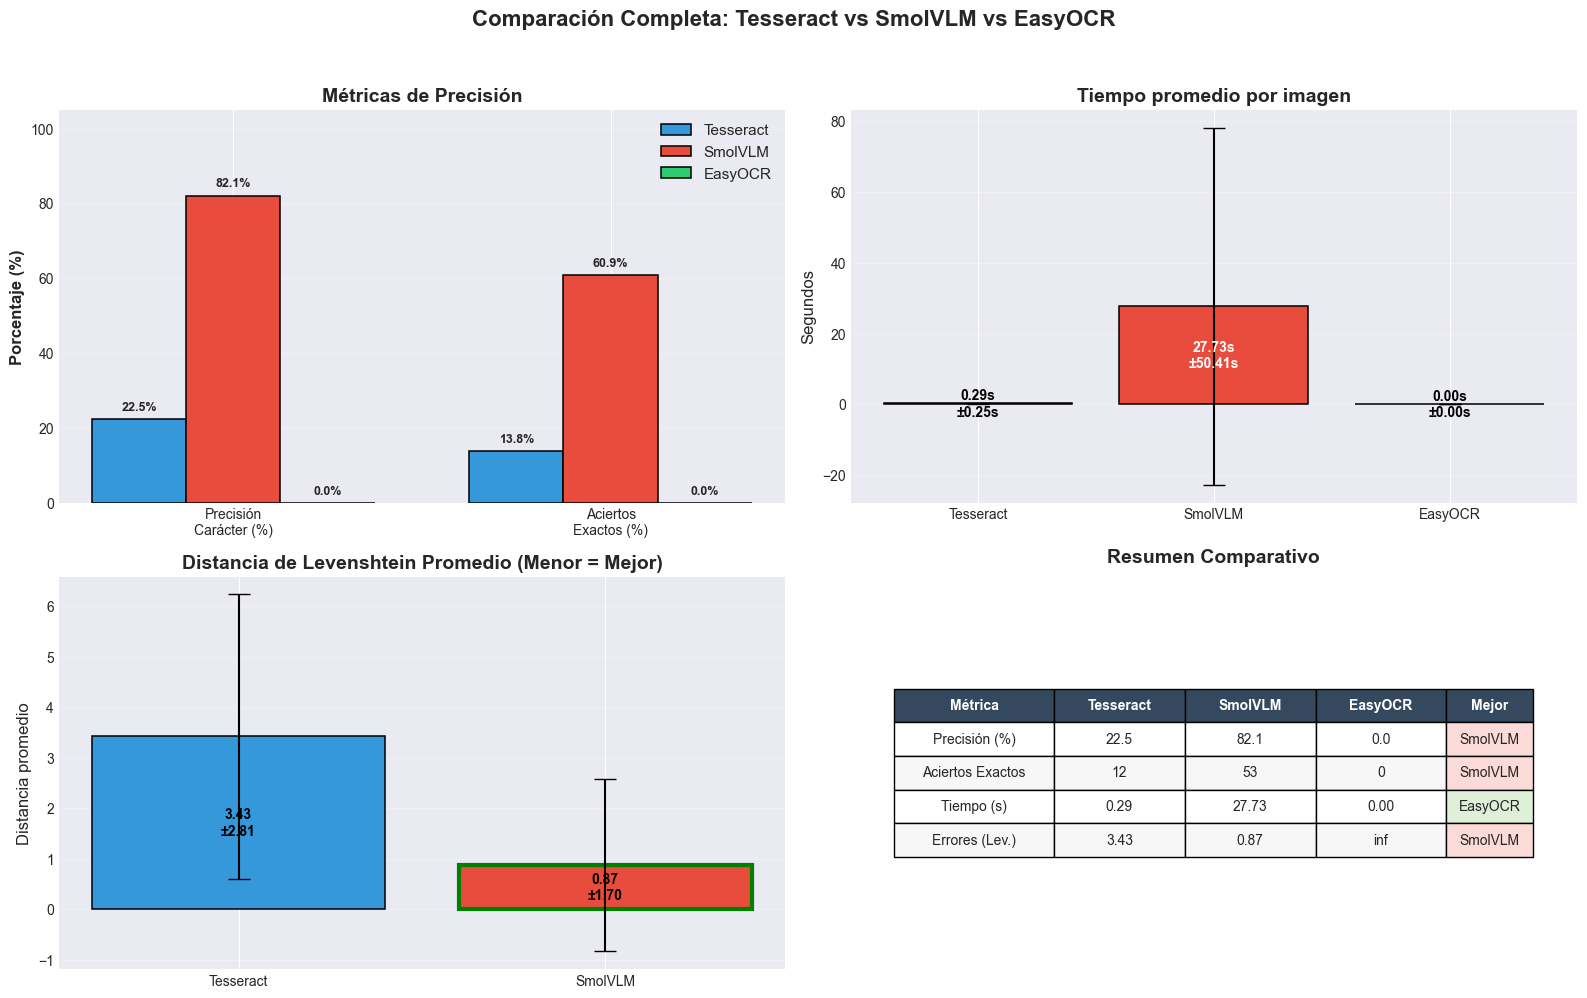

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

colors = ['#3498db', '#e74c3c', '#2ecc71']
method_names = ['Tesseract', 'SmolVLM', 'EasyOCR']

tess_char_pct = results_df['tesseract_char_accuracy'].mean() * 100
smol_char_pct = results_df['smolvlm_char_accuracy'].mean() * 100
easy_char_pct = results_df['easyocr_char_accuracy'].mean() * 100

tess_exact_pct = (results_df['tesseract_exact_match'].sum() / len(results_df)) * 100
smol_exact_pct = (results_df['smolvlm_exact_match'].sum() / len(results_df)) * 100
easy_exact_pct = (results_df['easyocr_exact_match'].sum() / len(results_df)) * 100


tess_avg_time = results_df['tesseract_time'].mean()
smol_avg_time = results_df['smolvlm_time'].mean()
easy_avg_time = results_df['easyocr_time'].mean()
avg_times = [tess_avg_time, smol_avg_time, easy_avg_time]
std_times = [
    results_df['tesseract_time'].std(),
    results_df['smolvlm_time'].std(),
    results_df['easyocr_time'].std()
]


tess_lev = results_df['tesseract_levenshtein'].mean()
smol_lev = results_df['smolvlm_levenshtein'].mean()
easy_lev = results_df['easyocr_levenshtein'].mean()
avg_levenshtein = [tess_lev, smol_lev, easy_lev]
std_lev = [
    results_df['tesseract_levenshtein'].std(),
    results_df['smolvlm_levenshtein'].std(),
    results_df['easyocr_levenshtein'].std()
]


precision_scores = [tess_char_pct, smol_char_pct, easy_char_pct]
exact_counts = [
    results_df['tesseract_exact_match'].sum(),
    results_df['smolvlm_exact_match'].sum(),
    results_df['easyocr_exact_match'].sum()
]
times_seconds = avg_times
lev_errors = avg_levenshtein

# Crear panel 2x2
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Comparación Completa: Tesseract vs SmolVLM vs EasyOCR', fontsize=16, fontweight='bold', y=0.995)


metrics = ['Precisión\nCarácter (%)', 'Aciertos\nExactos (%)']
tess_scores = [precision_scores[0], (exact_counts[0] / len(results_df)) * 100]
smol_scores = [precision_scores[1], (exact_counts[1] / len(results_df)) * 100]
easy_scores = [precision_scores[2], (exact_counts[2] / len(results_df)) * 100]

x = np.arange(len(metrics))
width = 0.25

bars1 = ax1.bar(x - width, tess_scores, width, label='Tesseract', color=colors[0], edgecolor='black', linewidth=1.1)
bars2 = ax1.bar(x, smol_scores, width, label='SmolVLM', color=colors[1], edgecolor='black', linewidth=1.1)
bars3 = ax1.bar(x + width, easy_scores, width, label='EasyOCR', color=colors[2], edgecolor='black', linewidth=1.1)

ax1.set_ylabel('Porcentaje (%)', fontweight='bold')
ax1.set_title('Métricas de Precisión', fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(metrics)
ax1.legend()
ax1.grid(axis='y', alpha=0.25)
ax1.set_ylim(0, 105)

for bars in (bars1, bars2, bars3):
    for bar in bars:
        h = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2, h + 1.5, f'{h:.1f}%', ha='center', va='bottom', fontsize=9, fontweight='bold')


ax2.bar(method_names, avg_times, yerr=std_times, capsize=8, color=colors, edgecolor='black', linewidth=1.1)
ax2.set_title('Tiempo promedio por imagen', fontweight='bold')
ax2.set_ylabel('Segundos')
ax2.grid(axis='y', alpha=0.25)

for i, (m, val) in enumerate(zip(method_names, avg_times)):
    ax2.text(i, val/2 if val>0 else 0.01, f'{val:.2f}s\n±{std_times[i]:.2f}s', ha='center', va='center',
             fontsize=10, fontweight='bold', color='white' if val > max(avg_times)*0.25 else 'black')


bars = ax3.bar(method_names, avg_levenshtein, yerr=std_lev, capsize=8, color=colors, edgecolor='black', linewidth=1.1)
ax3.set_title('Distancia de Levenshtein Promedio (Menor = Mejor)', fontweight='bold')
ax3.set_ylabel('Distancia promedio')

# Resaltar el ganador (menor distancia)
winner_idx = int(np.argmin(avg_levenshtein))
bars[winner_idx].set_edgecolor('green')
bars[winner_idx].set_linewidth(3)

for i, bar in enumerate(bars):
    h = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2, h/2, f'{h:.2f}\n±{std_lev[i]:.2f}', ha='center', va='center',
             fontsize=10, fontweight='bold', color='white' if h > max(avg_levenshtein)*0.25 else 'black')

ax3.grid(axis='y', alpha=0.25)


ax4.axis('off')
ax4.set_title('Resumen Comparativo', fontweight='bold', pad=10)

summary_data = [
    ['Métrica', 'Tesseract', 'SmolVLM', 'EasyOCR', 'Mejor'],
    ['Precisión (%)', f'{precision_scores[0]:.1f}', f'{precision_scores[1]:.1f}', f'{precision_scores[2]:.1f}',
     'Tesseract' if precision_scores[0] > max(precision_scores[1], precision_scores[2]) else ('SmolVLM' if precision_scores[1] > precision_scores[2] else 'EasyOCR')],
    ['Aciertos Exactos', f'{exact_counts[0]}', f'{exact_counts[1]}', f'{exact_counts[2]}',
     'Tesseract' if exact_counts[0] > max(exact_counts[1], exact_counts[2]) else ('SmolVLM' if exact_counts[1] > exact_counts[2] else 'EasyOCR')],
    ['Tiempo (s)', f'{times_seconds[0]:.2f}', f'{times_seconds[1]:.2f}', f'{times_seconds[2]:.2f}',
     'Tesseract' if times_seconds[0] < min(times_seconds[1], times_seconds[2]) else ('SmolVLM' if times_seconds[1] < times_seconds[2] else 'EasyOCR')],
    ['Errores (Lev.)', f'{lev_errors[0]:.2f}', f'{lev_errors[1]:.2f}', f'{lev_errors[2]:.2f}',
     'Tesseract' if lev_errors[0] < min(lev_errors[1], lev_errors[2]) else ('SmolVLM' if lev_errors[1] < lev_errors[2] else 'EasyOCR')]
]

table = ax4.table(cellText=summary_data, cellLoc='center', loc='center', colWidths=[0.22, 0.18, 0.18, 0.18, 0.12])
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 1.8)

# Estilos: cabecera y resaltar ganador por fila
n_rows = len(summary_data)
n_cols = len(summary_data[0])
for i in range(n_rows):
    for j in range(n_cols):
        cell = table[(i, j)]
        # Cabecera
        if i == 0:
            cell.set_facecolor('#34495e')
            cell.set_text_props(weight='bold', color='white')
        else:
            # Resaltar columna 'Mejor'
            if j == (n_cols - 1):
                winner = summary_data[i][j]
                if winner == 'Tesseract':
                    cell.set_facecolor('#d5f4e6')
                elif winner == 'SmolVLM':
                    cell.set_facecolor('#fadbd8')
                else:
                    cell.set_facecolor('#dff0d8')
            else:
                cell.set_facecolor('#f7f7f7' if i % 2 == 0 else 'white')

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()
